In [782]:
import pandas as pd
from pprint import pprint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings('ignore')

plt.style.use('default')


In [783]:
def load_data(path):
    """Load the dataset from the provided file path"""
    try:
        return pd.read_csv(path)
    except FileNotFoundError:
        print(f'File was not found at the location: {path}')

In [784]:
def explore_data(df):
    print('\nCOLUMN NAMES')
    print(df.columns.tolist())

    print('\nDATASET SHAPE')
    print(df.shape)

    print('\nBASIC INFO HIGHLIGHT')
    print(df.info())

    print('\nMEMORY USAGE')
    print(f'{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

    print('\nDATASET PREVIEW')
    print(df.head(7))

    print('\nBASIC STATISTICS')
    print(df.describe())

    print('\nMISSING VALUES')
    info_df = pd.DataFrame({
        'Data Types': df.dtypes,
        'Missing Values': df.isnull().sum(),
        'Missing %': ((df.isnull().sum() / len(df)) * 100).round(2)
    })
    print(info_df)

### Handling Missing Values

Preferably, when handling missing values for numerical columns, it's better to fill such columns with the median value which is more robust than mean or in some cases, the mode.

For categorical columns, you fill such columns with the mode (most frequent value)

In [785]:
def data_preparation(pdf):
    """Data preparation and cleaning"""
    
    df = pdf.copy()
    
    # Target variable has 3 possible classes: 'On Time', 'Delayed', and 'Defaulted'
    target_variable = 'repayment_status'
    
    # Encode categorical variables for past_default and target column
    # We'll use label encoding for simplicity
    label_encoders = {}
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    for column in categorical_columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le

    print('\nTarget Variable Distribution:')
    pprint(pdf[target_variable].value_counts().to_dict())

    feature_columns = df.drop(columns=target_variable, axis=1)
    target_column = df[target_variable]
    
    return df, feature_columns, target_column, label_encoders

In [786]:
def split_data(feature_columns, target_column):
    (X_train, X_test, y_train, y_test) = train_test_split(feature_columns, target_column, test_size=0.2, random_state=42, stratify=target_column)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # return X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_scaled, y_test
    return X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test


In [787]:
def train_models(X_train, X_train_scaled, X_test, X_test_scaled, y_train):
    """Train the different models"""
    
    models = {
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr'),
        'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10),
        'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=10),
    }
    
    # Train each model and store the result
    trained_models = {}
    predictions = {}
    
    for name, model in models.items():
        if name == 'LogisticRegression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)
            
        trained_models[name] = model
        predictions[name] = {
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
        }
    
    return models, trained_models, predictions

In [788]:
def evaluate_models(models, predictions, y_test):
    """Evaluate the performance of each of the trained models"""
    
    # Store all evaluation metrics
    results = []

    for name in models.keys():
        y_pred = predictions[name]['y_pred']
        y_pred_proba = predictions[name]['y_pred_proba']
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # For multi-class ROC-AUC, we'll calculate macro average
        # (Note: ROC-AUC for multi-class is more complex, we'll use macro averaging)
        try:
            # Binarize the output for multi-class ROC-AUC calculation
            print(y_test)
            y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])    
            n_classes = y_test_binarized.shape[1]
            
            print(y_test_binarized)

            # Calculate ROC-AUC for each class and take macro average
            roc_auc_scores = []
            
            for i in range(n_classes):
                # 
                if len(np.unique(y_test_binarized[:, i])) > 1:  # Check if class exists in test set
                    
                    # 
                    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
                    
                    # 
                    roc_auc_scores.append(auc(fpr, tpr))

            roc_auc = np.mean(roc_auc_scores) if roc_auc_scores else 0.0
        except:
            roc_auc = 0.0  # If ROC-AUC calculation fails
        
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'ROC_UAC': roc_auc,
        })
    
    results_df = pd.DataFrame(results)
    
    return results_df

In [789]:
def create_visualizations(df, models, y_test, predictions, label_encoders, trained_models, feature_columns):
    """Visualize evaluation metrics"""
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Model Performance Comparison (Bar Chart)
    plt.subplot(2, 3, 1)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_UAC']
    x = np.arange(len(metrics))
    width = 0.25
    
    for i, model in enumerate(df['Model']):
        values = [df.iloc[0][metric] for metric in metrics]    
        plt.bar(x + (i * width), values, width, label=model)

    plt.title('Model Performance Comparison')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    
    plt.xticks(x + width, metrics, rotation=45)
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    
    # 2. Confusion Matrix for each model
    for i, name in enumerate(models.keys()):
        plt.subplot(2, 3, i+2)
        cm = confusion_matrix(y_test, predictions[name]['y_pred'])
        
        labels = label_encoders['repayment_status'].classes_
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix for {name}'.format(name=name))
        plt.xlabel('Predicted Status')
        plt.ylabel('Default Status')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
    
    # TODO: ROC-Curve
    
    # 3. Feature Importance (for RandomForest model)
    plt.subplot(2, 3, 5)
    rf_model = trained_models['RandomForest']
    feature_importance = pd.DataFrame({
        'feature': feature_columns.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(10)
    
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title('Top 10 Most Important Features(Random Forest)')
    plt.xlabel('Feature Importance')
    
    plt.tight_layout()
    plt.show()    

In [790]:
def recommend_best_model(df, models, y_test, predictions):
    """Provide a recommendation for the best model to use"""

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_UAC']
    
    # Approach 1
    df['Overall_Score'] = df[metrics].mean(axis=1)
    best_model = df.loc[df['Overall_Score'].idxmax()]
    
    # Approach 2
    # model_scores = {}
    # 
    # for _, row in df.iterrows():
    #     score = (
    #         row['Accuracy'] +
    #         row['Precision'] +
    #         row['Recall'] +
    #         row['F1_Score'] +
    #         row['ROC_UAC']
    #     )
    #     
    #     model_scores[row['Model']] = score
        
    # best_model_2 = max(model_scores, key=model_scores.get)
    
    print('')
    
    print('\nJUSTIFICATION FOR REPAYMENT STATUS PREDICTION:')
    
    if best_model['Model'] == 'LogisticRegression':
        print('''
        RECOMMENDED MODEL: Logistic Regression
        
        Reasons:
        1. Easily interpreted
        2. Fast training and prediction
        ''')
        
    elif best_model['Model'] == 'RandomForest':
        print('''
        RECOMMENDED MODEL: Random Forest
        
        Reasons:
        1. Easily handle mixed data types
        2. Built-in feature importance
        ''')

    elif best_model['Model'] == 'DecisionTree':
        print('''
        RECOMMENDED MODEL: Decision Tree
        
        Reasons:
        1. Easy to visualize and explain to loan officers and customers
        2. Creates clear decision paths
        3. No need for feature scaling
        ''')
    
    print('\n\nDETAILED CLASSIFICATION REPORTS')
    print('='*50)
    for name in models.keys():
        print(f'====== {name} =====')
        print(classification_report(y_test, predictions[name]['y_pred']))

In [791]:
def main():
    credit_df = load_data('../../data/credit_scoring.csv')
    
    credit_df = credit_df.drop('customer_id', axis=1)

    explore_data(credit_df)

    (df, feature_columns, target_column, label_encoders) = data_preparation(credit_df)

    (X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test) = split_data(feature_columns, target_column)

    (models, trained_models, predictions) = train_models(X_train, X_train_scaled, X_test, X_test_scaled, y_train)

    evaluation_results = evaluate_models(models, predictions, y_test)
    
    print(evaluation_results)
    
    create_visualizations(evaluation_results, models, y_test, predictions, label_encoders, trained_models, feature_columns)

    recommend_best_model(evaluation_results, models, y_test, predictions)


Target Variable Distribution:
{'Defaulted': 6, 'Delayed': 3, 'On Time': 21}
14    0
11    2
28    2
17    2
1     1
27    2
Name: repayment_status, dtype: int64
[[1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]]
14    0
11    2
28    2
17    2
1     1
27    2
Name: repayment_status, dtype: int64
[[1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]]
14    0
11    2
28    2
17    2
1     1
27    2
Name: repayment_status, dtype: int64
[[1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]]
                Model  Accuracy  Precision    Recall  F1_Score   ROC_UAC
0  LogisticRegression  0.833333       0.75  0.833333  0.777778  0.866667
1        RandomForest  0.833333       0.70  0.833333  0.759259  1.000000
2        DecisionTree  0.833333       0.70  0.833333  0.759259  0.750000
[[1 0 0]
 [1 0 0]
 [0 0 4]]
[[1 0 0]
 [0 0 1]
 [0 0 4]]
[[1 0 0]
 [0 0 1]
 [0 0 4]]


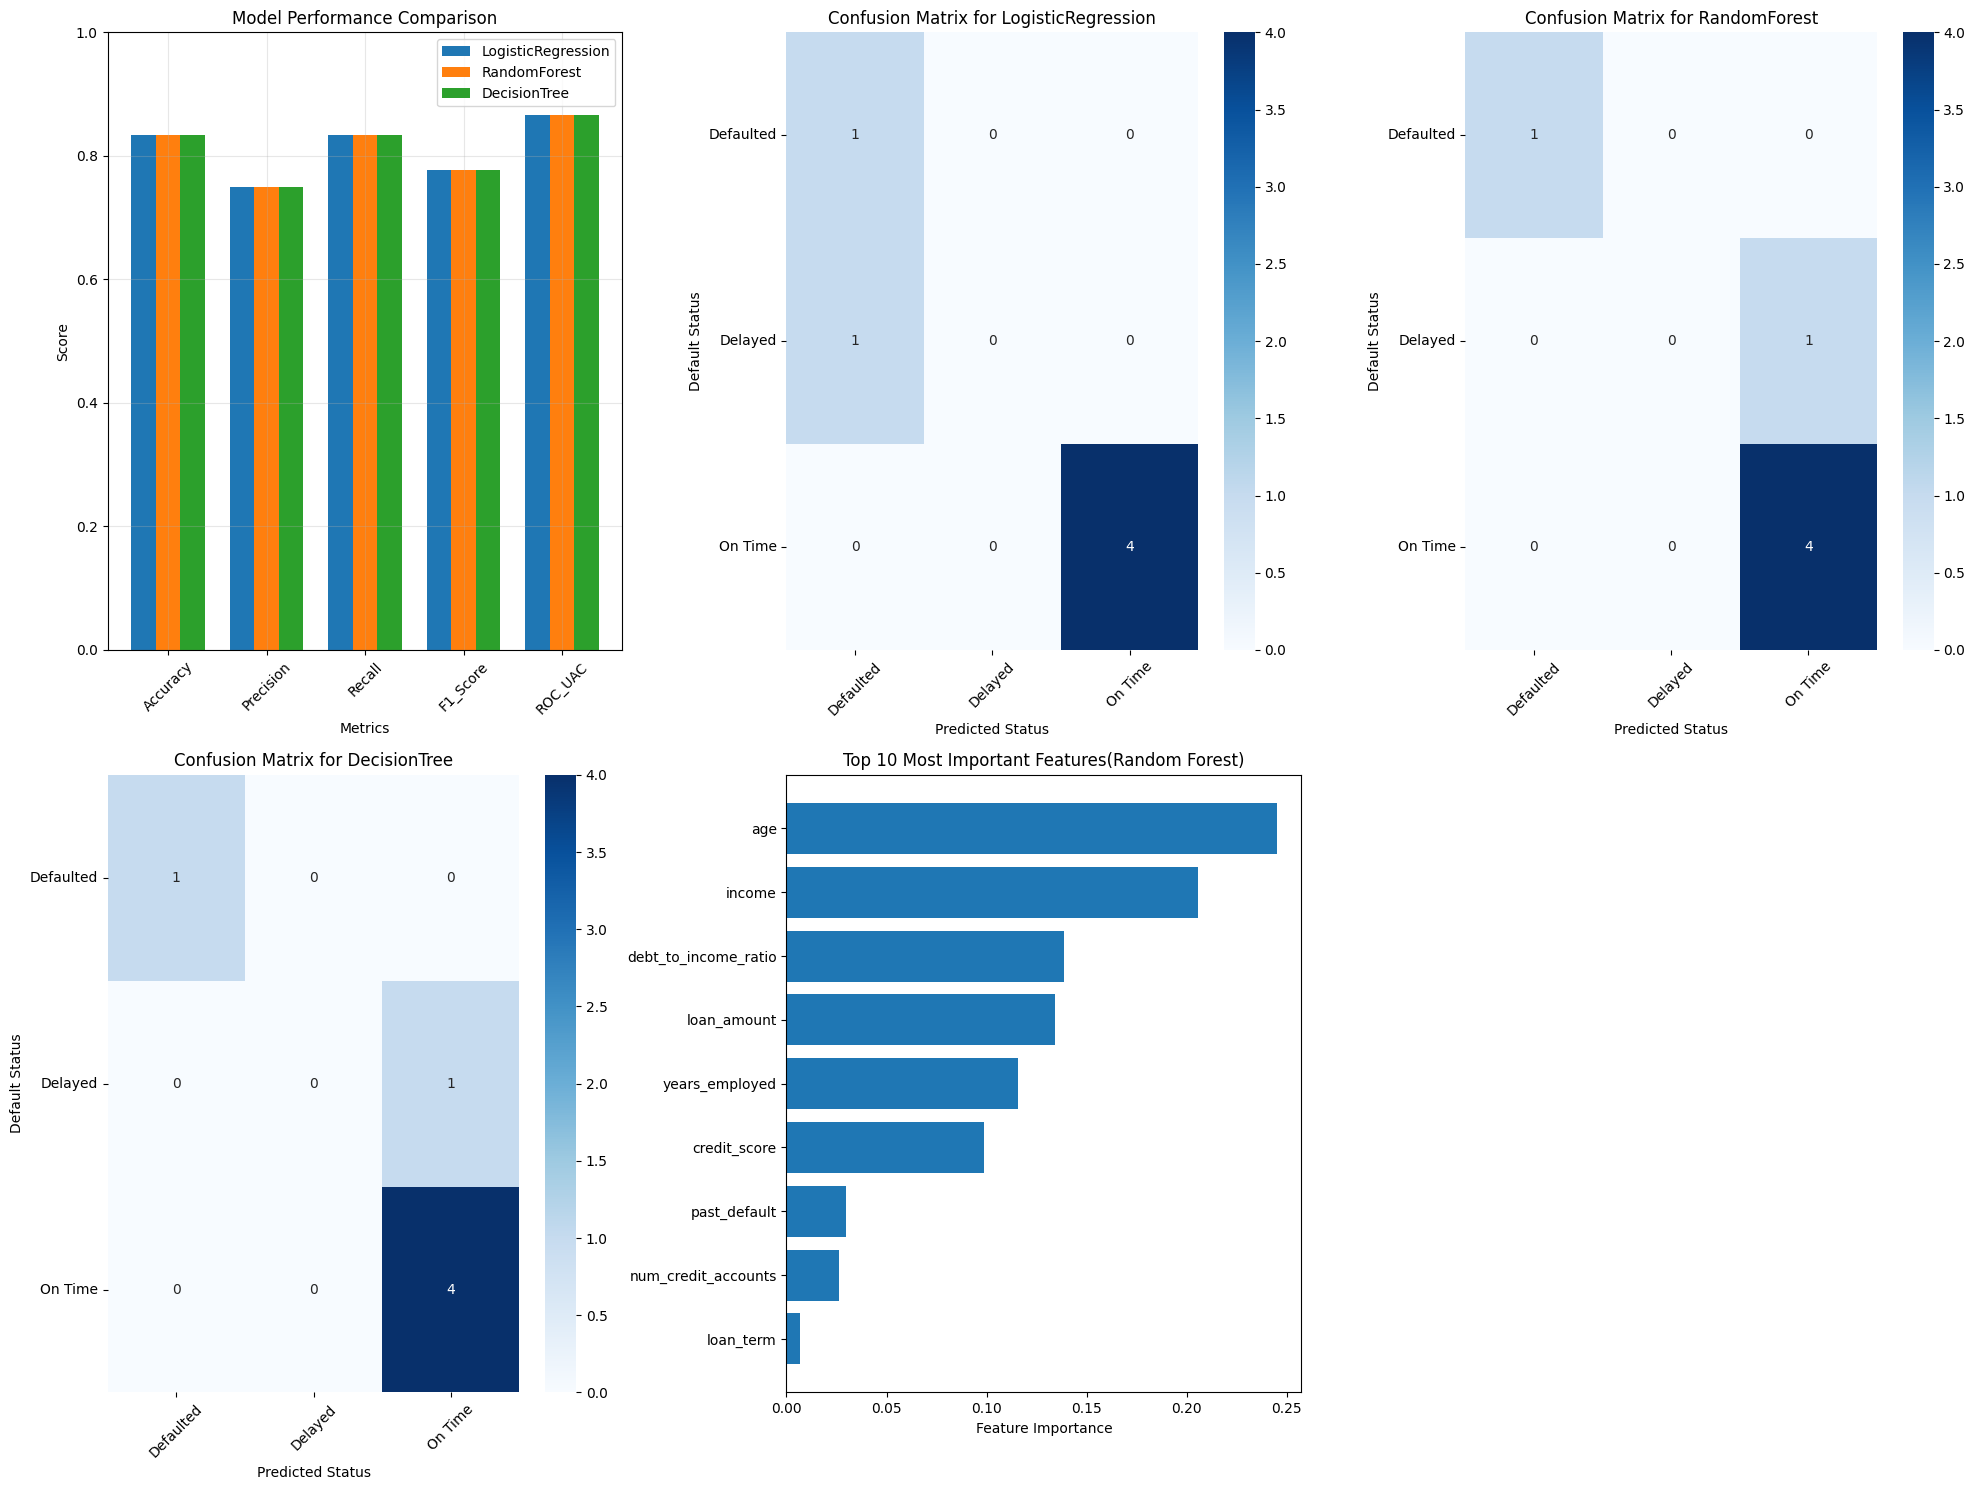



JUSTIFICATION FOR REPAYMENT STATUS PREDICTION:

        RECOMMENDED MODEL: Random Forest

        Reasons:
        1. Easily handle mixed data types
        2. Built-in feature importance
        


DETAILED CLASSIFICATION REPORTS
====== LogisticRegression =====
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         4

    accuracy                           0.83         6
   macro avg       0.50      0.67      0.56         6
weighted avg       0.75      0.83      0.78         6

====== RandomForest =====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.80      1.00      0.89         4

    accuracy                           0.83         6
   macro avg       0.60      0.67      0.63         6
we

In [792]:
if __name__ == '__main__':
    main()